# Modeling!!!

In [1]:
from pymongo import MongoClient
import os
import sys
import csv
import pandas as pd
import numpy as np
import importlib
import warnings
from collections import defaultdict

# custom module
from utils import utilsvectorizer as uv

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction import stop_words


# Plotting tools
import pyLDAvis
from pyLDAvis.sklearn import prepare
from pyLDAvis.gensim import prepare as prepare_gensim

# nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk import regexp_tokenize

# spacy for language processing
import spacy

# gensim for alternative models
from gensim.models import LdaModel, LdaMulticore, KeyedVectors, TfidfModel
from gensim.corpora import Dictionary
from gensim.matutils import Sparse2Corpus
from gensim.utils import tokenize, simple_preprocess, lemmatize

import matplotlib.pyplot as plt

/home/ceddie/anaconda3/envs/insight/lib/python3.6/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [2]:
# make sure we have the latest version of custom module loaded
importlib.reload(uv)
warnings.filterwarnings("ignore")

# automatically display LDA vis post prepare call
pyLDAvis.enable_notebook()

% matplotlib inline
plt.style.use('ggplot')

### Lemmatize stopwords from sklearn
In my custom tfidf vectorizer, lemmatization is done before removing stopwords. Therefore, 'has' becomes 'ha' post lemmatization and 'has' is a stopword!

In [3]:
# sklearn english stopwords
sw_sklearn = stop_words.ENGLISH_STOP_WORDS
# lemmatization to convert plurals words to singular word
Lem = WordNetLemmatizer()
# # lemmatize those and update our list
# sw_sklearn = set([Lem.lemmatize(s) for s in sw_sklearn ])
# # add other common
# # sw = sw_sklearn.union(names_corp)
# sw = sw_sklearn

### Get Data from MongoDB

In [4]:
# Create a client connection to the MongoDb instance running on the local machine
client = MongoClient('localhost:27017')

In [5]:
# connect to database of interest
db = client.awards_tmp

In [6]:
# cursor_tmp is a generator
cursor_tmp = db.awards_tmp.find({}, {'Amount' : 1,
                                     'amount_corrected' : 1,
                                     'Agency' : 1,
                                     'Branch' : 1,
                                     'Abstract' : 1,
                                     'company name' : 1,
                                     'DUNS' : 1,
                                     'title' : 1,
                                     'Awards Year' : 1,
                                     'Phase':1,
                                     'Contract': 1,
                                     '_id': False} )
# need a new cursor (generator) after you used it
df = pd.DataFrame(list(cursor_tmp))

In [7]:
# convert Awards year to datetime object
df['Awards Year'] = pd.to_datetime(df['Awards Year'])

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167412 entries, 0 to 167411
Data columns (total 11 columns):
Abstract            167412 non-null object
Agency              167405 non-null object
Amount              167412 non-null float64
Awards Year         167412 non-null datetime64[ns]
Branch              82443 non-null object
Contract            167412 non-null object
DUNS                167412 non-null object
Phase               167412 non-null object
amount_corrected    167412 non-null float64
company name        167412 non-null object
title               167412 non-null object
dtypes: datetime64[ns](1), float64(2), object(8)
memory usage: 14.0+ MB


In [9]:
# df.head()

In [10]:
# mark 'N/A' abstract by nan
df.loc[df.Abstract == 'N/A', 'Abstract'] = np.nan

In [11]:
# concatenate abstract and title
df['text'] = df.Abstract.add(df.title, fill_value = '')

### Add agency abbreviation

In [12]:
agency_name = {'usda' : 'Department of Agriculture',
                'doc' : 'Department of Commerce',
                'dod' : 'Department of Defense',
                'ed' : 'Department of Education',
                'doe' : 'Department of Energy',
                'hhs' : 'Department of Health and Human Services',
                'dhs' : 'Department of Homeland Security',
                'dot' : 'Department of Transportation',
                'epa' : 'Environmental Protection Agency',
                'nasa' : 'National Aeronautics and Space Administration',
                'nsf' : 'National Science Foundation'}

In [13]:
agency_map = {v: k for k, v in agency_name.items()}

In [14]:
df['agency_abbr'] = df.Agency.map(agency_map)

In [15]:
agency = df.agency_abbr.value_counts().index

In [16]:
len(agency), agency

(11,
 Index(['dod', 'hhs', 'nasa', 'nsf', 'doe', 'usda', 'epa', 'doc', 'ed', 'dot',
        'dhs'],
       dtype='object'))

In [17]:
# agency = ['dot', 'dhs']

## Choose one Agency

In [84]:
ag = 'hhs'
print('Modeling {}'.format(ag))
# discard 0 amount, N/A abstract. Agency shall not be missing and only consider Phase I
crit = (df.agency_abbr == ag) & (df.Phase == 'Phase I') & \
        (df.amount_corrected > 0) & (df['Awards Year'] >= '2000') & \
        (df.Abstract.notnull())
df_analysis = df.loc[crit,:].copy()
df_analysis.shape

Modeling hhs


(16651, 13)

In [85]:
# target training data
y_docs = df_analysis.amount_corrected.values

In [86]:
# years for stratified train/test
strat_years = df_analysis.iloc[:, df_analysis.columns.get_loc('Awards Year') ]

In [87]:
# features training data
docs = df_analysis.Abstract.values

## Add lower case to spacy pipeline (optional)

In [88]:
# could use larger model (en_core_web_lg)
# SpaCy has 3 pipelines by default, ['parser', 'tagger', 'ner']

# Only keep tagger as it also lower case tokens
# nlp = spacy.load('en', disable=['parser', 'ner'])

In [89]:
# def lower_case(doc):
#     return [d.lower_ for d in doc]

In [90]:
# try:
#     nlp.remove_pipe('lower_case')
# except:
#     nlp.add_pipe(lower_case, name='lower_case', last=True)

In [91]:
# nlp.pipe_names

## Tokenize text
1. Get alphanumeric terms ('(?u)\\b\\w\\w+\\b')
2. lower case
3. remove stopwords
4. lemmatize

In [92]:
# from spacy.lang.en.stop_words import STOP_WORDS
# print(len(STOP_WORDS), len(sw_sklearn))

In [93]:
# len([w.lemma_ for w in nlp(docs[0]) if (not w.is_punct) & (not w.is_space) & (not w.is_stop) & (w.pos_ != 'PRON') ])

In [94]:
# # Tokenize and compile list of token list
# # nlp does lower case each token
# docs_list = []

# for d in docs:
#     # remove punctuation, space, stopwords, pronouns
#     docs_list.append([w.lemma_ for w in nlp(d) 
#                      if (not w.is_punct) & (not w.is_space) & (not w.is_stop) & (w.pos_ != 'PRON') ])

In [95]:
docs_list = []

# boolean mask to keep track of out of model documents
mask_notempty_doc = np.full_like(docs , True, dtype=bool)

for ind, d in enumerate(docs):
    # alpahnumeric tokens
    tokens = regexp_tokenize(d, '(?u)\\b\\w\\w+\\b')
    
    # lower case
    tokens_low = [t.lower() for t in tokens]
    
    # remove stopwords and lemmatize
    tokens_lem = [ Lem.lemmatize(w) for w in tokens_low if w not in sw_sklearn ]
    
    # mark this doc as empty
    if not tokens_lem:
        mask_notempty_doc[ind] = False
    else:
        docs_list.append(tokens_lem)

In [96]:
sum([ 1 for d in docs_list if not d])

0

### Adjust target and strat_years to remove empty documents

In [97]:
y_docs = y_docs[mask_notempty_doc]
strat_years = strat_years[mask_notempty_doc]
len(docs_list), y_docs.shape, strat_years.shape

(16600, (16600,), (16600,))

### Train/Test split

In [98]:
# split documents in train/test, labels are optional here. It turns out we know them.
X_train, X_test, y_train, y_test = train_test_split( docs_list,
                                    y_docs,
                                    test_size = 0.3,
                                    random_state = 7,
                                    stratify = strat_years)

In [99]:
print(len(X_train), len(X_test))

11620 4980


### Derive tf-idf model

In [100]:
# collect words and associated word counts
dictionary = Dictionary(X_train)
# dictionary.filter_extremes(no_below=min_df, no_above=max_df, keep_n=max_features)

In [101]:
# BAG-OF-WORD
# list of tuples list: (word_id, count)
# word_id is from the dictionary
corpus = [dictionary.doc2bow(doc) for doc in X_train]

In [102]:
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 57568
Number of documents: 11620


In [103]:
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

In [104]:
# Train tfidf on our bag-of-word
model_tfidf = TfidfModel(corpus=corpus, id2word=id2word, dictionary=dictionary)

### Load Word2Vec model (skip grams, 300d) and create word2vec tf-idf weighted average class

In [39]:
#load in word2vec, and define functions for parsing tokenized episode summaries.
# This model used skip-gram on Google News data, made in 2013 (100B words)
word2vec_dir = os.path.join(os.pardir, 'models', 'GoogleNews-vectors-negative300.bin')
word2vec = KeyedVectors.load_word2vec_format(word2vec_dir, binary=True)

In [40]:
def get_word_vectors(dictionary, tfidf_corpus, word2vec):
    """
        compile list of word vectors and its assciated tf-idf value
        from a corpus.
        Return a tuple of two list, tfidf values and word vectors
        INPUT:
            dictionary, used to recover word as a string from its index
            tfidf_corpus, tf-idf output from one document/corpus
            word2vec, pre-trained model
    """
    vw_not_found = []
    # list of tf-idf weights for existing word vectors
    # some word do not have a vector representation
    tfidf_weights = []

    # list of word vectors
    wvector_list = []

    # collect all word vectors
    for d, dtf in tfidf_corpus:

        # first element of tfidf_corpus is the word id
        # retrieve word (string) from dictionary
        term = dictionary.get(d)

        # check if word exist in model
        if term in word2vec.wv.vocab:

            # word2vec returns a numpy array
            # store array in list
            wvector_list.append(word2vec[term])

            # keep track of tfidf coefficient for this word
            # 2nd element of tfidf_corpus is the term frequency
            tfidf_weights.append(dtf)
        else:
            vw_not_found.append(term)
            
    return tfidf_weights, wvector_list, vw_not_found

In [41]:
def document_vectorizer(corpus, dictionary, model_tfidf, word2vec):
    """
        Document vector based on Tf-idf weighted average of word vectors from that document.
        
        Return N dimension vector, N being model dimension ,and boolean mask 
        for missing document vectors (i.e. not a single word had a vector representation)
    """
    # list for document vectors
    dvector = []
    # list of token list not in word2vec
    dvw_notfound = []

    # boolean mask to keep track of out of model documents
    mask_doc = np.full((len(corpus),), True, dtype=bool)

    # analyze each corpus
    for ind, corp in enumerate(corpus):

        # get tf-idf based on bow corpus
        tfidf_corpus = model_tfidf[corp]

        # get word vectors and associated tfidf
        tfidf_weights, wvector_list, wv_notfound = get_word_vectors(dictionary, tfidf_corpus, word2vec)
        
        # keep track of word vector not in word2vec
        dvw_notfound.append(wv_notfound)
        
        # skip document/corpus when not a single word found in word2vec model
#         if len(wvector_list) < 20:
        if not wvector_list:
            # flip this record for subsequent filtering
            mask_doc[ind] = False
            continue

        # consolidate all word vectors (2d numpy array, 300xnum_doc)
        words_array = np.stack(wvector_list, axis = 1)
        
# simple mean
#         doc_vector = words_array.mean(axis = 1)
# OR weighted mean

        # create 1d numpy array from tfidf weight list
        tfidf_array = np.array(tfidf_weights)

        # term-frequency correction factor
        # number of terms per document changed
        # old_total_term / new_total_term
        tfidf_array = tfidf_array * len(tfidf_corpus) / len(tfidf_weights)

        # document vector (tfidf weighted average of word vector)
        doc_vector = np.dot(words_array, tfidf_array) / tfidf_array.sum()
        
        dvector.append(doc_vector)

    # consolidate document vectors
    doc_array_train = np.stack(dvector)
    
    return doc_array_train, mask_doc, dvw_notfound

In [105]:
doc_array_train, mask_doc, dvw_notfound = document_vectorizer(corpus, dictionary, model_tfidf, word2vec)

In [106]:
doc_array_train.shape

(11620, 300)

In [107]:
# number of tokens per documents
num_token = np.array([len(corp) for corp in corpus])
print('Average number of tokens per document: ', num_token.mean())

Average number of tokens per document:  128.74965576592083


In [108]:
# average number of tokens without vector representation 
num_token_missed = np.array([ len(d) for d in dvw_notfound])
print('Average number of non-vectorized words per document:', num_token_missed.mean())
np.percentile(num_token_missed, [25, 50, 75, 90 ])

Average number of non-vectorized words per document: 5.605507745266781


array([ 2.,  4.,  8., 12.])

In [109]:
# pecentage of document without missing word vectors
sum([ 1 for d in dvw_notfound if not d]) / len(dvw_notfound) * 100

8.777969018932874

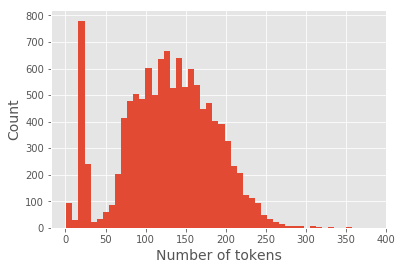

In [110]:
_ = plt.hist(num_token, bins=50)
plt.xlabel('Number of tokens', fontsize = 14)
plt.ylabel('Count', fontsize = 14)
plt.savefig(os.path.join(os.pardir, 'reports', 'figures', 'Token_distrib_HHS.png'))

4.254748374196665


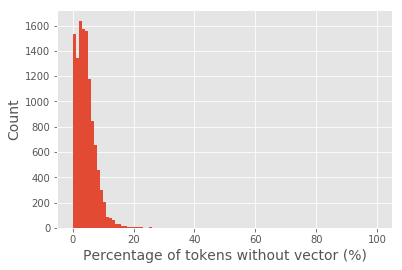

In [111]:
percent_missing = (num_token_missed / num_token) *100
print(percent_missing.mean())
_ = plt.hist(percent_missing, range=(0,100), bins=100)
plt.xlabel('Percentage of tokens without vector (%)', fontsize = 14)
plt.ylabel('Count', fontsize = 14)
plt.savefig(os.path.join(os.pardir, 'reports', 'figures', 'Percent_token_novector_HHS.png'))

#### Check words not found by word2vec per document
Mostly empty list as a result of tokenization

In [60]:
dvw_notfound[89]

['12',
 'escherichia',
 '506',
 'adjuv',
 'extraintestinal',
 'hylaxis',
 'nanoencapsulation',
 'th1',
 'therapyx',
 'tpx',
 'vaccina']

In [76]:
with open(''.join([ag, '_no_w2v.txt']), 'w') as f:
    wr = csv.writer(f)
    wr.writerows(dvw_notfound)

#### Check document without any words having a vector representation

In [73]:
(np.array(X_train)[~mask_doc])

array([], dtype=object)

## Modeling!

In [48]:
rf = RandomForestRegressor(n_jobs = -1, n_estimators = 200, min_samples_split = 2)

In [49]:
# perform grid search CV on pipeline
_ = rf.fit(doc_array_train, y_train[mask_doc])

In [50]:
# training set score
y_train_pred = rf.predict(doc_array_train)
r2_train = r2_score(y_train[mask_doc], y_train_pred)
print('Train score = ', r2_train)

Train score =  0.8566315817065009


In [51]:
# Take a look at each tree depth
sum([estimator.tree_.max_depth for estimator in rf.estimators_ ])/ rf.n_estimators

46.3

## Prepare test data

In [52]:
corpus_test = [dictionary.doc2bow(doc) for doc in X_test]

In [53]:
doc_array_test, mask_doc_test, dvw_notfound_test = \
                document_vectorizer(corpus_test, dictionary, model_tfidf, word2vec)

In [54]:
doc_array_test.shape

(5093, 300)

In [55]:
# dvw_notfound_test[98]

In [56]:
# (np.array(X_test)[~mask_doc_test])

In [57]:
# test set score
y_test_pred = rf.predict(doc_array_test)
r2_test = r2_score(y_test[mask_doc_test], y_test_pred)
print('Test score = ', r2_test)

Test score =  -0.02042451402208889


In [66]:
# pickle model
joblib.dump(rf, os.path.join(os.pardir,'models', ''.join([ag, '_rf_phase1_w2v.pkl']) ) )

['../models/hhs_rf_phase1_w2v.pkl']

## Trying Extra Trees

In [67]:
from sklearn.ensemble import ExtraTreesRegressor

In [68]:
et = ExtraTreesRegressor(n_jobs = -1, n_estimators = 200, min_samples_split = 2, max_features = 100)

In [69]:
# perform grid search CV on pipeline
_ = et.fit(doc_array_train, y_train[mask_doc])

In [70]:
# training set score
y_train_pred = et.predict(doc_array_train)
r2_train = r2_score(y_train[mask_doc], y_train_pred)
print('Train score = ', r2_train)

Train score =  0.9966681656026551


In [71]:
# test set score
y_test_pred = et.predict(doc_array_test)
r2_test = r2_score(y_test[mask_doc_test], y_test_pred)
print('Test score = ', r2_test)

Test score =  0.06044756112631222


In [72]:
joblib.dump(rf, os.path.join(os.pardir,'models', ''.join([ag, '_et_phase1_w2v.pkl']) ) )

['../models/hhs_et_phase1_w2v.pkl']

## Similarity

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
# tv_dtm: output of vectorizer
tv_matrix = tv_dtm.toarray()

similarity_matrix = cosine_similarity(tv_matrix)

## Experimenting

In [ ]:
# process first document
first_tfidf = model_tfidf[corpus[0]]

In [ ]:
tfidf_weights = np.array([ weight for _, weight in first_tfidf])

In [ ]:
# keep track of existing word vector
tfidf_mask = np.full((len(corpus[0]),), True, dtype=bool)

words_array = []
for ind, d in enumerate(corpus[0]):
    
    # first element of d is the word id
    # retrieve word (string) from word id
    term = dictionary.get(d[0])
    
    # check if word exist in model
    if term in word2vec.wv.vocab:
        # word2vec returns a numpy array
        # store array in list
         words_array.append(word2vec[term])
    else:
        tfidf_mask[ind] = False

In [ ]:
# consolidate all word vectors (numpy arrays)
words_array = np.stack(words_array, axis = 1)

In [ ]:
len(docs_list[0]), tfidf_weights[tfidf_mask].shape, words_array.shape

In [ ]:
# document vector (tfidf weighted average of word vector)
np.dot(words_array, tfidf_weights[tfidf_mask]) / tfidf_weights[tfidf_mask].sum()

## Failed class and pipeline

In [ ]:
class TfidfEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        self.dim = word2vec.vector_size

    def fit(self, X, y):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        # if a word was never seen - it must be at least as infrequent
        # as any of the known words - so the default idf is the max of 
        # known idf's
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf,
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])

        return self

    def transform(self, X):
        return np.array([
                np.mean([self.word2vec[w] * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])

In [ ]:
vec = TfidfEmbeddingVectorizer(word2vec)

In [ ]:
vec.fit(docs_list, y_docs)

In [ ]:
vec.transform(docs_list)

In [ ]:
reg = Pipeline([
                ("word2vec_vectorizer", TfidfEmbeddingVectorizer(word2vec)),
                ("rf", RandomForestRegressor())])

parameters = {
              'rf__n_estimators': [ 10 ],
              'rf__min_samples_split': [ 3 ],
              'rf__max_depth': [ 10 ]
             }


# set up grid search using all of my cores
# I believe R^2 is the default scorer for Lasso
gs_reg = GridSearchCV(reg, param_grid = parameters,\
                      scoring='neg_mean_squared_error',\
                      cv = 3 , n_jobs= -1, verbose=1)